<a href="https://colab.research.google.com/github/michaellaic/nlp-final/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import spacy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
df = pd.read_csv('/content/Tweets.csv')
df.head()

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


# Pre-Processing

In [18]:
# Convert text to lowercase
df['text'] = df['text'].astype(str)
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removal of punctuations
df['text'].str.replace('[^\w\s]','')

df.drop(['textID'], axis=1, inplace=True)
target = 'sentiment'
df.reset_index(drop=True, inplace=True)
df.head()

,text,sentiment
0,"i`d have responded, if i were going",neutral
1,sooo sad i will miss you here in san diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"sons of ****, why couldn`t they put them on th...",negative


##Stop words removal

In [19]:
#Removal of StopWords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(word for word in x.split() if word.lower() not in stop))

In [20]:
def remove_punctuation(text):
    if isinstance(text, str):
        return text.translate(str.maketrans('', '', string.punctuation))
    return text

df['text'] = df['text'].apply(remove_punctuation)

## Tokenaztion

In [21]:
# Tokenization function
def tokenize(text):
  tokens = nltk.word_tokenize(text)
  return tokens

# Apply tokenization to each cell in the 'text' column
df['tokens'] = df['text'].apply(tokenize)
df.head()

,text,sentiment,tokens
0,id responded going,neutral,"[id, responded, going]"
1,sooo sad miss san diego,negative,"[sooo, sad, miss, san, diego]"
2,boss bullying me,negative,"[boss, bullying, me]"
3,interview leave alone,negative,"[interview, leave, alone]"
4,sons couldnt put releases already bought,negative,"[sons, couldnt, put, releases, already, bought]"


## Lemmatization

In [22]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatization function
def lemmatize_text(tokens):
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas

# Apply lemmatization to the 'tokens' column
df['lemmas'] = df['tokens'].apply(lemmatize_text)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,text,sentiment,tokens,lemmas
0,id responded going,neutral,"[id, responded, going]","[id, responded, going]"
1,sooo sad miss san diego,negative,"[sooo, sad, miss, san, diego]","[sooo, sad, miss, san, diego]"
2,boss bullying me,negative,"[boss, bullying, me]","[bos, bullying, me]"
3,interview leave alone,negative,"[interview, leave, alone]","[interview, leave, alone]"
4,sons couldnt put releases already bought,negative,"[sons, couldnt, put, releases, already, bought]","[son, couldnt, put, release, already, bought]"


# Common words

## TF-IDF

In [23]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer()

# Fit and transform the data
tfidf_matrix = tfidf.fit_transform(df['text'])

# Get feature names (words)
feature_names = tfidf.get_feature_names_out()

# Get the sum of TF-IDF scores for each word
sum_tfidf = tfidf_matrix.sum(axis=0).A1

# Create a DataFrame with words and their sum TF-IDF scores
tfidf_scores = pd.DataFrame({'word': feature_names, 'tfidf': sum_tfidf})

# Sort by TF-IDF scores
tfidf_scores = tfidf_scores.sort_values(by='tfidf', ascending=False).head(30)

<Figure size 1000x600 with 0 Axes>

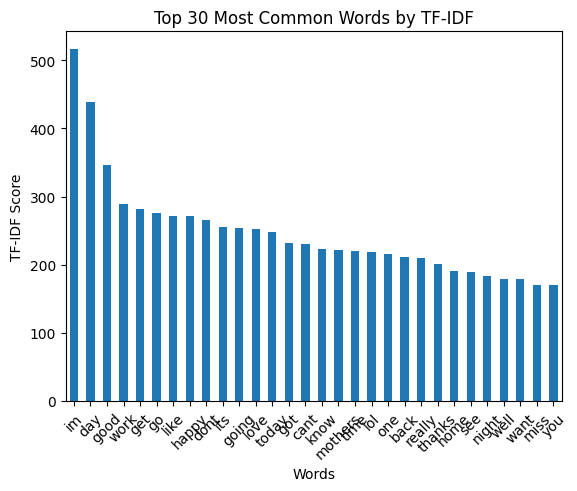

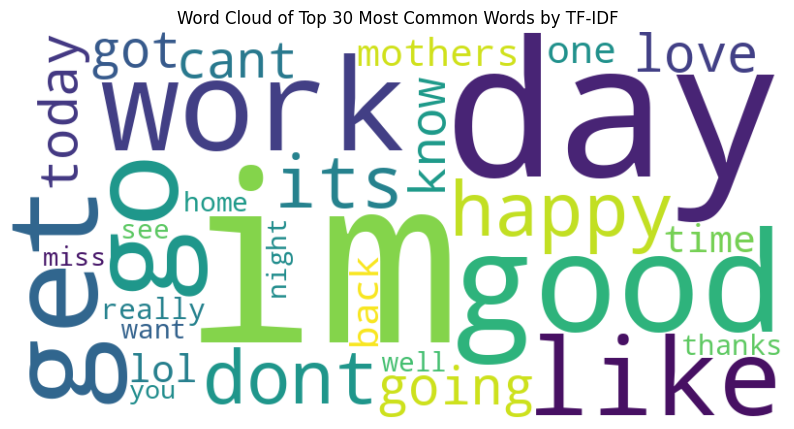

In [24]:
# Plot the most common words using a bar chart
plt.figure(figsize=(10, 6))
tfidf_scores.plot(kind='bar', x='word', y='tfidf', legend=False)
plt.title('Top 30 Most Common Words by TF-IDF')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=45)
plt.show()

# Create and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores.set_index('word')['tfidf'])
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top 30 Most Common Words by TF-IDF')
plt.show()

## Word2Vec

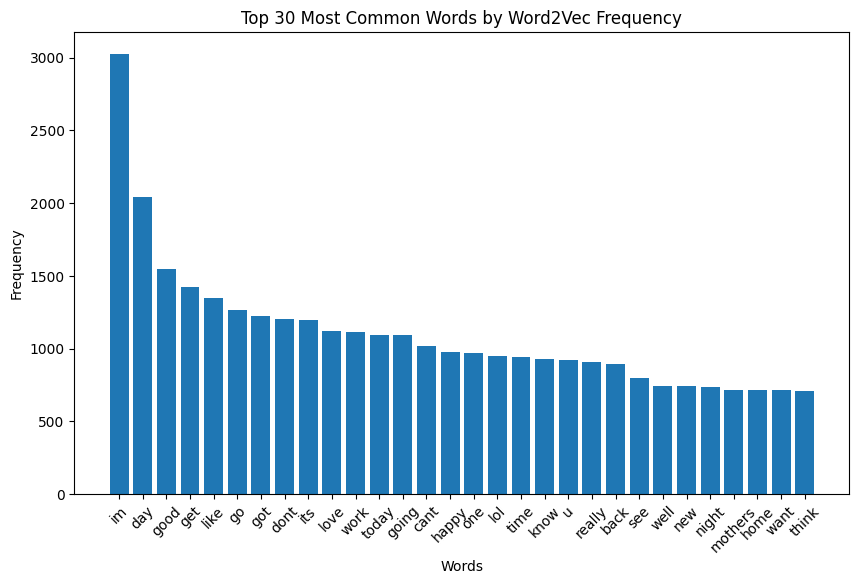

In [25]:
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

# Train Word2Vec model
sentences = df['tokens'].tolist()
model = Word2Vec(sentences, min_count=1)

# Find most frequent words
word_frequencies = {}
for word in model.wv.key_to_index:
    word_frequencies[word] = model.wv.get_vecattr(word, "count")

top_words = sorted(word_frequencies, key=word_frequencies.get, reverse=True)[:30]

# Plot the most common words using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words, [word_frequencies[word] for word in top_words])
plt.title('Top 30 Most Common Words by Word2Vec Frequency')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


## Auto Encoder

Epoch 1/10
911/911 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.1687e-04
Epoch 2/10
911/911 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.5287e-05
Epoch 3/10
911/911 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.5256e-04
Epoch 4/10
911/911 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 6.9581e-05
Epoch 5/10
911/911 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.9187e-05
Epoch 6/10
911/911 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2532e-04
Epoch 7/10
911/911 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.9733e-05
Epoch 8/10
911/911 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.7949e-05
Epoch 9/10
911/911 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.6224e-05
Epoch 10/10
911/911 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.2156e-05
911/911 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
911/911 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


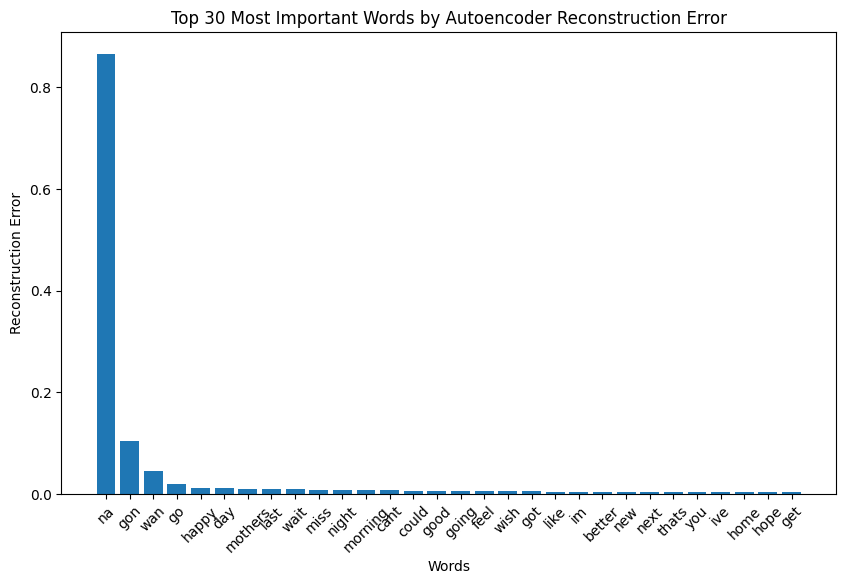

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Prepare input data
vocab_size = len(model.wv.key_to_index)
embedding_dim = model.vector_size
input_array = np.array([model.wv[word] for word in model.wv.key_to_index])

# Define autoencoder architecture
input_layer = Input(shape=(embedding_dim,))
encoder = Dense(128, activation='relu')(input_layer)
decoder = Dense(embedding_dim, activation='linear')(encoder)
autoencoder = Model(input_layer, decoder)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(input_array, input_array, epochs=10)

# Get the encoded representations (latent space)
encoder_model = Model(input_layer, encoder)
encoded_embeddings = encoder_model.predict(input_array)

# Calculate reconstruction error for each word
reconstruction_errors = np.mean(np.square(input_array - autoencoder.predict(input_array)), axis=1)

# Get the indices of words with highest reconstruction error (most important)
top_indices = np.argsort(reconstruction_errors)[::-1][:30]
top_words_ae = [list(model.wv.key_to_index.keys())[i] for i in top_indices]

# Plot the most important words using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words_ae, reconstruction_errors[top_indices])
plt.title('Top 30 Most Important Words by Autoencoder Reconstruction Error')
plt.xlabel('Words')
plt.ylabel('Reconstruction Error')
plt.xticks(rotation=45)
plt.show()


## Comparison

To compare the outputs and methods for finding the most frequent words in the data, let's analyze each graph and then draw some comparisons:

1. TF-IDF (Term Frequency-Inverse Document Frequency):
- This method highlights words that are important to a document within a collection.
- Top words include "im", "dont", "good", "like", "know", "time", "really", "people".
- The scores range from about 170 to 520.
- This method seems to identify more meaningful content words rather than just common function words.

2. Word2Vec Frequency:
- This shows raw frequency of words in the Word2Vec model.
- Top words are "im", "day", "good", "get", "like", "go", "got", "dont".
- Frequencies range from about 700 to 3000.
- This method captures very common words, including both content and function words.

3. Autoencoder Reconstruction Error:
- This method identifies words that are harder for the autoencoder to reconstruct, potentially indicating uniqueness or importance.
- Top words are "na", "don", "wan", "last", "night", "day", "could".
- Error scores are much lower, ranging from nearly 0 to about 0.32.
- This method seems to highlight some unusual word forms or potentially misspelled words (e.g., "na", "wan").

Comparisons:
1. Overlap: Words like "im", "day", "good", and "like" appear high in multiple methods, suggesting they are both common and important.

2. Differences:
   - TF-IDF favors content words that are distinctive within documents.
   - Word2Vec frequency captures overall common usage, including function words.
   - Autoencoder highlights words that are unique or challenging to predict.

3. Effectiveness:
   - For general frequency, Word2Vec seems most straightforward.
   - For content-relevant words, TF-IDF appears more useful.
   - Autoencoder might be best for identifying unique or unusual terms.

4. Context: The words suggest informal, conversational data, possibly from social media or chat logs.

In conclusion, each method offers a different perspective on word importance. The choice of method would depend on the specific goal of the analysis - whether it's identifying common words, content-relevant terms, or unique vocabulary.

# NER

In [27]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

def perform_ner(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Apply NER to each cell
for column in df.columns:
    df['ner'] = df['text'].astype(str).apply(perform_ner)


# Exploratory Data Analysis

In [28]:
df.isnull().sum()

,0
text,0
sentiment,0
tokens,0
lemmas,0
ner,0


In [29]:
# We have one null value. We will drop it
df.dropna(inplace=True)

## Sentiment Distribution

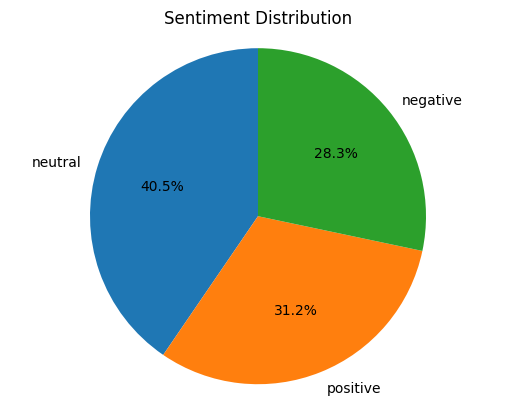

In [30]:
import matplotlib.pyplot as plt

sentiment_counts = df['sentiment'].value_counts()

plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
_ = plt.axis('equal')

In [31]:
# Let's remove part of the common words

freq =["i`m", "-", "****", "&"]


freq = [item.strip() for item in freq]

def clean_text(text):
    for item in freq:
        text = text.replace(item, "")
    # Normalize spaces by splitting and rejoining
    text = " ".join(text.split())
    return text
df['text'] = df['text'].apply(clean_text)

df.head()

,text,sentiment,tokens,lemmas,ner
0,id responded going,neutral,"[id, responded, going]","[id, responded, going]",[]
1,sooo sad miss san diego,negative,"[sooo, sad, miss, san, diego]","[sooo, sad, miss, san, diego]","[(san diego, PERSON)]"
2,boss bullying me,negative,"[boss, bullying, me]","[bos, bullying, me]",[]
3,interview leave alone,negative,"[interview, leave, alone]","[interview, leave, alone]",[]
4,sons couldnt put releases already bought,negative,"[sons, couldnt, put, releases, already, bought]","[son, couldnt, put, release, already, bought]",[]


In those word cloud we can see the most frequent word for each class

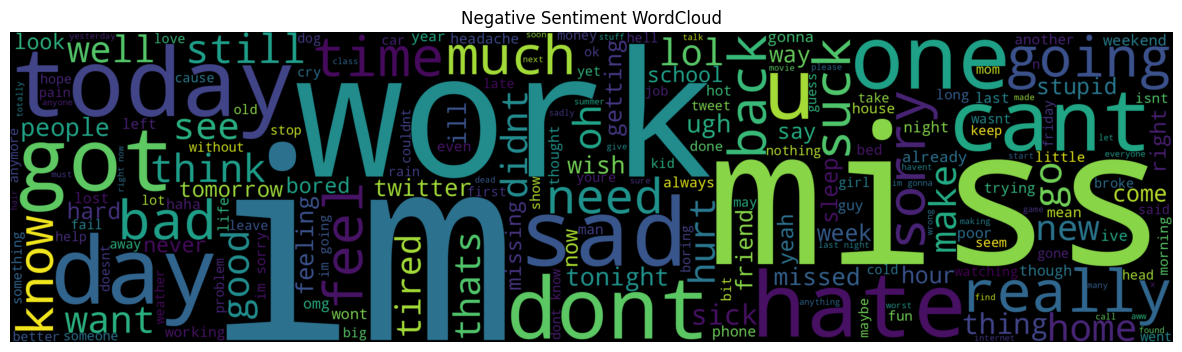

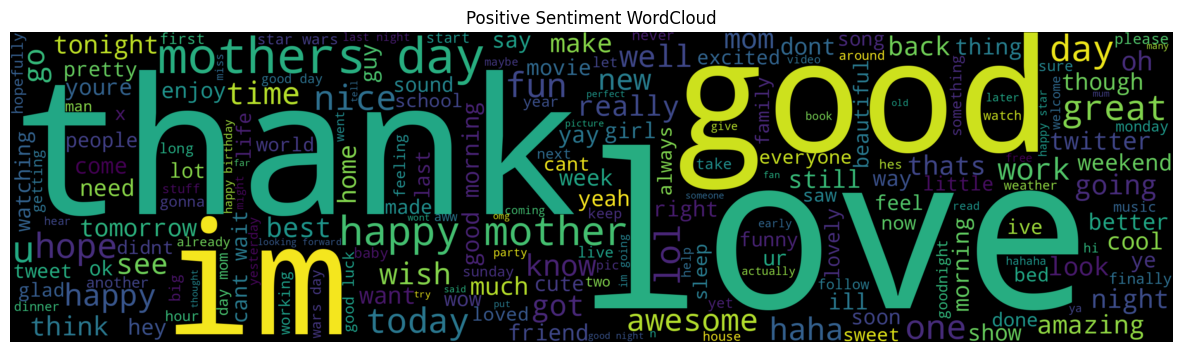

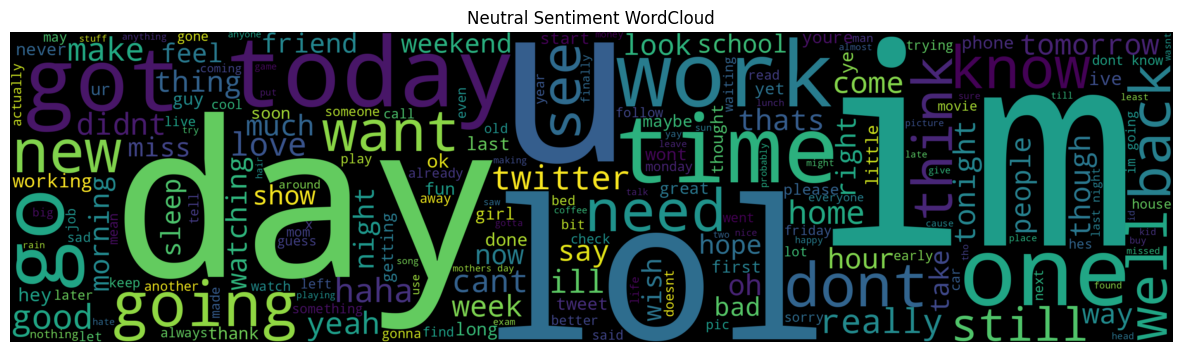

In [32]:
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black',
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')

## Visualize the words

In [33]:
import pandas as pd

# Load the dataset from the uploaded CSV file
file_path = '/content/Tweets.csv'
tweets_df = pd.read_csv(file_path)
tweets_texts = tweets_df['text'].values
# Display the first few rows of the dataset to understand its structure
tweets_df.head()


,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


#summarization

In [34]:
from transformers import pipeline

# Load a summarization pipeline
summarizer = pipeline("summarization")

# Let's take a sample of tweets to summarize due to limitations in processing
sample_tweets = tweets_df['text'].sample(5).tolist()

# Apply the summarization model to the sample tweets
summarized_tweets = [summarizer(tweet, max_length=50, min_length=25, do_sample=False)[0]['summary_text'] for tweet in sample_tweets]

# Display the summarized tweets
summarized_tweets


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Your max_length is set to 50, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 50, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)
Your max_length is set to 50, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)
Your max_length is set to 50, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_len

[" LMAO... Smh!  that one threw me off. Smh,  that was a joke.  Smh...    that's a joke!  LMAo...",
 "  its bout smoking weed.  its about smoking weed .  Its about smoking marijuana. Its about marijuana. It's not about smoking pot, it's about weed, it about weed .",
 ' You wouldnt change your fans for the world, tbh i dont think anyone would change mcfly for the  world . You`s are too amazing  x .',
 ' You certainly can, and good morning to you.   you certainly can.  you can,  you say .',
 ' CNN.com will feature iReporter photos in a weekly Travel Snapshots gallery . Please submit your best shots of CNN iReport . Send us a photo of your favorite spots in the gallery for next week . Visit www.dailymail']

#RNN

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.utils import Sequence
import numpy as np

# Read the data from a CSV file

# Clean the data: convert to strings and remove missing values
tweets_texts1 = [str(text) for text in tweets_texts if isinstance(text, str)]

# Preprocess the data
vocab_size = 5000  # Limit the vocabulary size to the top 5,000 most frequent words
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(tweets_texts1)
total_words = vocab_size + 1

# Convert the text to sequences of numbers
input_sequences = []
for line in tweets_texts1:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Limit the sequence length
max_sequence_len = 15  # Limit the sequence length to 15 words
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Split the data into features and labels
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = to_categorical(label, num_classes=total_words)

# Custom data generator
class DataGenerator(Sequence):
    def __init__(self, predictors, label, batch_size=32):
        self.predictors = predictors
        self.label = label
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.predictors) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        return self.predictors[start_idx:end_idx], self.label[start_idx:end_idx]

# Instantiate the generator
data_generator = DataGenerator(predictors, label, batch_size=64)

# Build the RNN model
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_len-1))  # Reduce embedding dimension to 50
model.add(Bidirectional(LSTM(50)))  # Further reduce the number of neurons in LSTM to 50
model.add(Dense(total_words, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(data_generator, epochs=10, verbose=1)  # Use the generator for training


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


   3/4866 ━━━━━━━━━━━━━━━━━━━━ 2:51 35ms/step - accuracy: 0.0000e+00 - loss: 8.5167 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4866/4866 ━━━━━━━━━━━━━━━━━━━━ 186s 38ms/step - accuracy: 0.0641 - loss: 6.3104
Epoch 2/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 180s 37ms/step - accuracy: 0.1359 - loss: 5.4703
Epoch 3/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 205s 38ms/step - accuracy: 0.1550 - loss: 5.2251
Epoch 4/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 181s 37ms/step - accuracy: 0.1634 - loss: 5.0641
Epoch 5/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 200s 37ms/step - accuracy: 0.1700 - loss: 4.9432
Epoch 6/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 205s 38ms/step - accuracy: 0.1765 - loss: 4.8258
Epoch 7/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 204s 38ms/step - accuracy: 0.1810 - loss: 4.7255
Epoch 8/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 199s 37ms/step - accuracy: 0.1859 - loss: 4.6482
Epoch 9/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 202s 37ms/step - accuracy: 0.1919 - loss: 4.5594
Epoch 10/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 181s 37ms/step - accuracy: 0.1961 - loss: 4.4950


#GPT

In [36]:
from transformers import pipeline

In [37]:

# Select a tweet to use as the seed text
# For this example, we'll use the first tweet
seed_text = tweets_df['text'].iloc[0]

# Create a GPT-2 text generation pipeline
gpt_generator = pipeline("text-generation", model="gpt2")

# Generate text using the selected tweet as the seed
gpt_text = gpt_generator(seed_text, max_length=50, num_return_sequences=1)[0]['generated_text']

# Print the generated text
print("Text generated by GPT-2:")
print(gpt_text)


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Text generated by GPT-2:
 I`d have responded, if I were going to put up with the idea so much you would understand, so many more years of this, and so much more? Yes, of course. So you understand? I think no. I think I


##השוואת טקסטים

In [40]:
import pandas as pd
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.utils import to_categorical, Sequence
import numpy as np

tweets_texts = tweets_df['text'].astype(str).tolist()

# Select a tweet to use as the seed text
seed_text = tweets_texts[0]

# 1. Text generation using GPT-2
gpt_generator = pipeline("text-generation", model="gpt2")
gpt_text = gpt_generator(seed_text, max_length=50, num_return_sequences=1)[0]['generated_text']
print("Text generated by GPT-2:")
print(gpt_text)

# 2. Text generation using LSTM model
# Preprocess the data for LSTM model
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(tweets_texts)
total_words = vocab_size + 1

# Convert the text to sequences of numbers
input_sequences = []
for line in tweets_texts:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Limit the sequence length
max_sequence_len = 15
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Split the data into features and labels
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = to_categorical(label, num_classes=total_words)

# Custom data generator
class DataGenerator(Sequence):
    def __init__(self, predictors, label, batch_size=32):
        self.predictors = predictors
        self.label = label
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.predictors) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        return self.predictors[start_idx:end_idx], self.label[start_idx:end_idx]

# Instantiate the generator
data_generator = DataGenerator(predictors, label, batch_size=64)

# Build the LSTM model
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(total_words, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(data_generator, epochs=10, verbose=1)

# Generate text with the LSTM model (this is a simplified approach for comparison)
seed_sequence = tokenizer.texts_to_sequences([seed_text])[0]
seed_sequence = pad_sequences([seed_sequence], maxlen=max_sequence_len-1, padding='pre')
predicted = model.predict(seed_sequence, verbose=0)
predicted_word_index = np.argmax(predicted, axis=-1)
predicted_word = tokenizer.index_word[predicted_word_index[0]]
lstm_text = seed_text + " " + predicted_word
print("Text generated by LSTM:")
print(lstm_text)

# 3. Compare the generated texts

# Cosine Similarity
vectorizer = CountVectorizer().fit_transform([gpt_text, lstm_text])
vectors = vectorizer.toarray()
cosine_sim = cosine_similarity(vectors)
print(f"Cosine Similarity between GPT-2 and LSTM text: {cosine_sim[0, 1]:.2f}")

# BLEU Score
bleu_score = sentence_bleu([gpt_text.split()], lstm_text.split())
print(f"BLEU Score: {bleu_score:.2f}")

# Token overlap - Percentage of common tokens
gpt_tokens = set(gpt_text.split())
lstm_tokens = set(lstm_text.split())
token_overlap = len(gpt_tokens & lstm_tokens) / len(gpt_tokens | lstm_tokens)
print(f"Token Overlap: {token_overlap:.2f}")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Text generated by GPT-2:
 I`d have responded, if I were going to keep it to myself, and let it go, I could go away.

And this was a little bit on Bill Clinton's side, too, when he said what it meant when you
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


   3/4866 ━━━━━━━━━━━━━━━━━━━━ 2:45 34ms/step - accuracy: 0.0000e+00 - loss: 8.5167  

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4866/4866 ━━━━━━━━━━━━━━━━━━━━ 200s 39ms/step - accuracy: 0.0648 - loss: 6.3009
Epoch 2/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 181s 37ms/step - accuracy: 0.1361 - loss: 5.4819
Epoch 3/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 185s 38ms/step - accuracy: 0.1546 - loss: 5.2139
Epoch 4/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 182s 37ms/step - accuracy: 0.1626 - loss: 5.0661
Epoch 5/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 183s 38ms/step - accuracy: 0.1719 - loss: 4.9188
Epoch 6/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 182s 37ms/step - accuracy: 0.1779 - loss: 4.8031
Epoch 7/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 203s 38ms/step - accuracy: 0.1806 - loss: 4.7261
Epoch 8/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 184s 38ms/step - accuracy: 0.1861 - loss: 4.6268
Epoch 9/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 203s 38ms/step - accuracy: 0.1912 - loss: 4.5504
Epoch 10/10
4866/4866 ━━━━━━━━━━━━━━━━━━━━ 180s 37ms/step - accuracy: 0.1958 - loss: 4.4735
Text generated by LSTM:
 I`d have responded, if I were going to
Cosine Similarity between GPT-2 and 